# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data.

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/train_val.zip")
zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks")
zip_ref.close()

## Imports

In [ ]:
import random
import shutil
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
import pandas as pd
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.applications import VGG16

## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

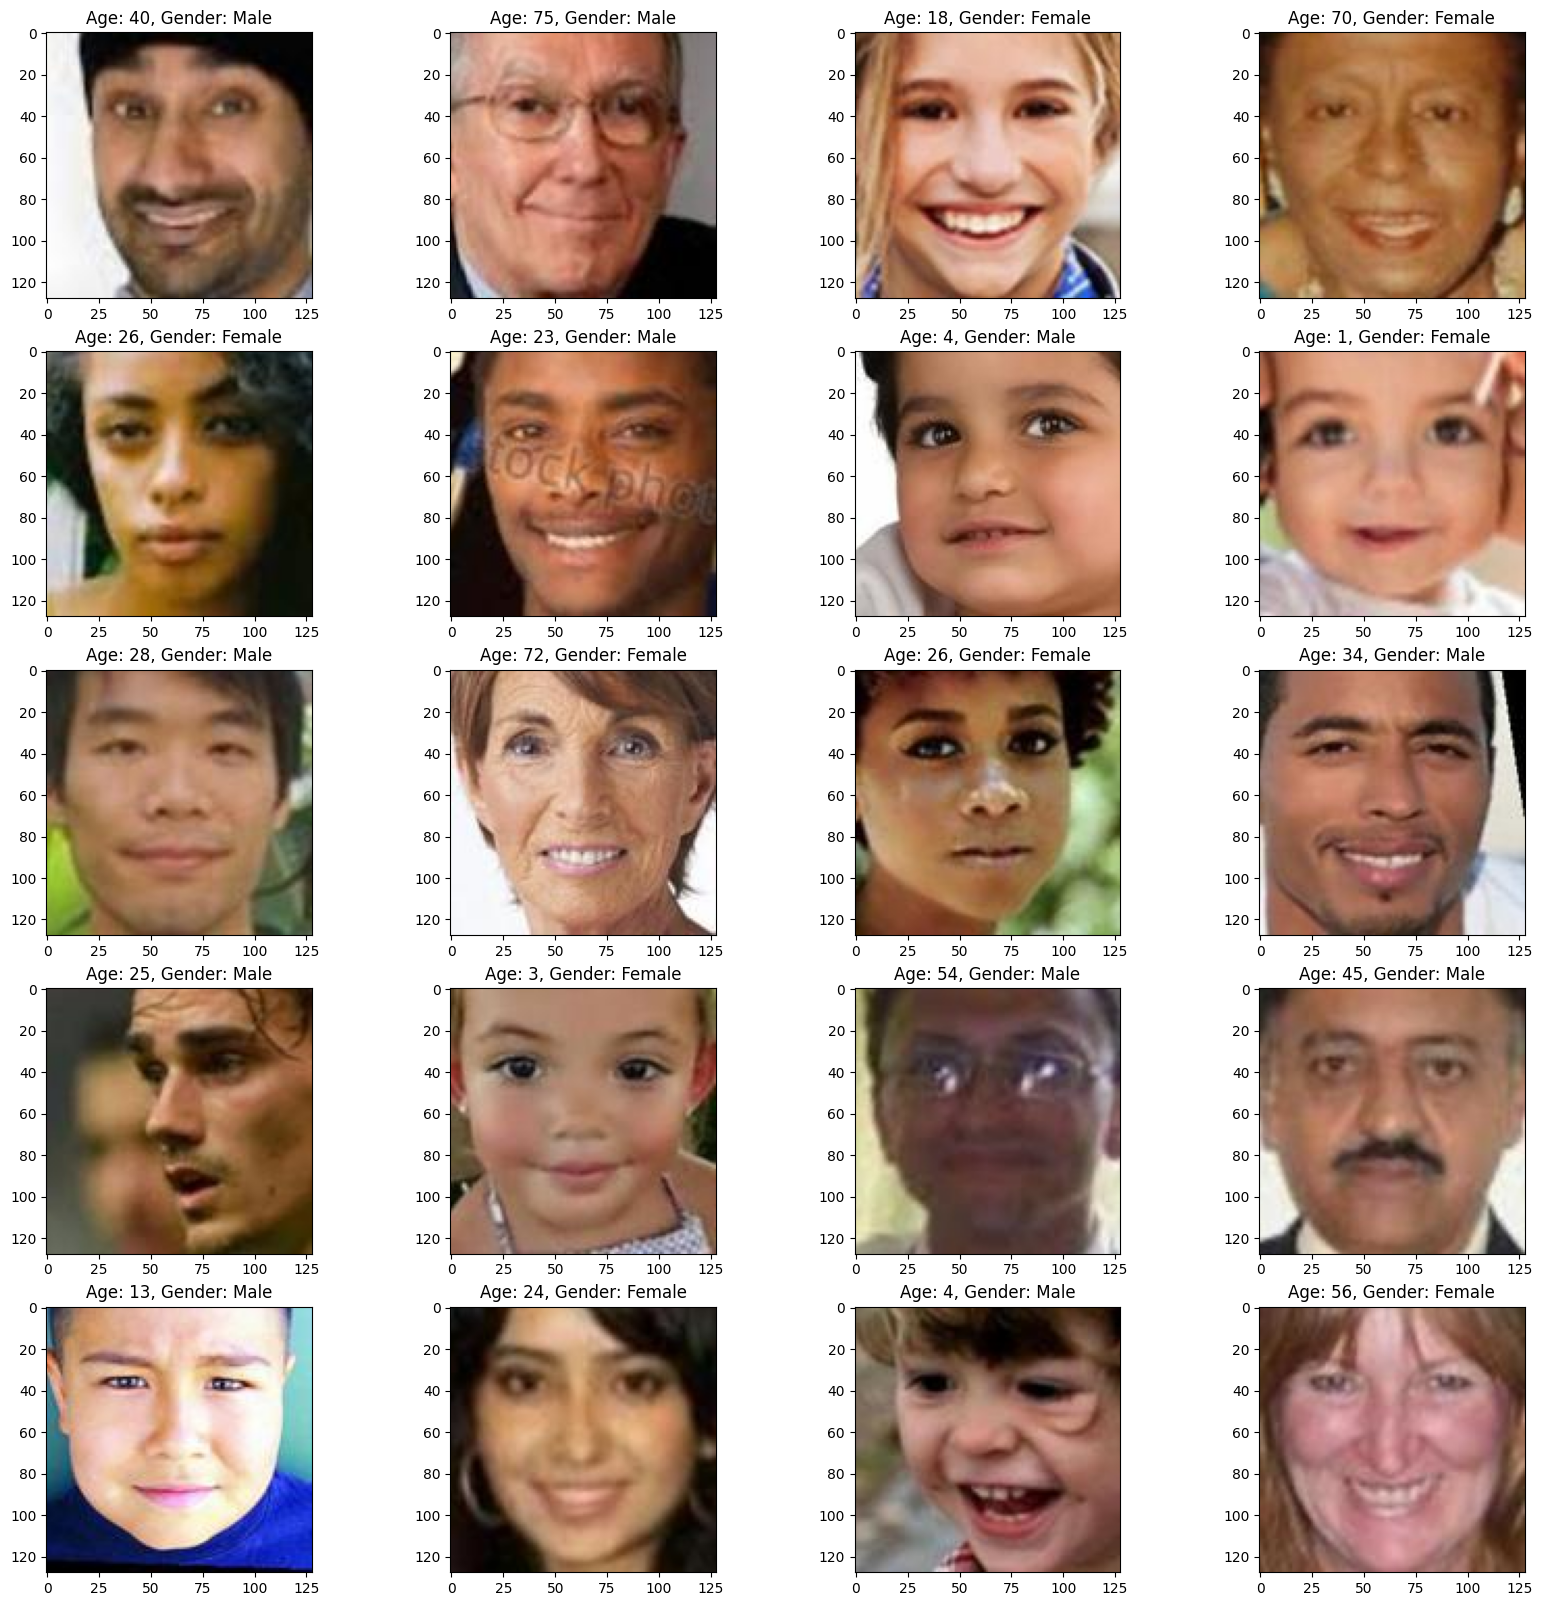

In [ ]:
folder = '/content/drive/MyDrive/Colab Notebooks/train_val'

def get_age_gender(filename):
    parts = filename.split('_')
    age = parts[0]
    gender = 'Male' if parts[1] == '0' else 'Female'
    return age, gender

plt.figure(figsize=(20,20))
for i in range(20):
    filename = os.listdir(folder)[i]
    full_path = os.path.join(folder, filename)

    if not os.path.exists(full_path):
        print('No such file:', full_path)
        continue

    image = imread(full_path)
    age, gender = get_age_gender(filename)
    plt.subplot(5, 4, i+1)
    plt.imshow(image)
    plt.title(f'Age: {age}, Gender: {gender}')

plt.show()

# New section

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
def directory_contains_files(directory):
    for _, _, files in os.walk(directory):
        if files:
            return True
    return False

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/train_val'
train_dir = '/content/drive/MyDrive/Colab Notebooks/train_dir'
val_dir = '/content/drive/MyDrive/Colab Notebooks/validation_dir'
if not os.path.exists(train_dir):
    os.makedirs(train_dir, exist_ok=True)

if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)


if not directory_contains_files(train_dir):
    image_files = os.listdir(data_dir)
    random.shuffle(image_files)
    split_index = int(0.8 * len(image_files))
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]

    for file in train_files:
        src = os.path.join(data_dir, file)
        dest = os.path.join(train_dir, file)
        shutil.copy(src, dest)

    for file in val_files:
        src = os.path.join(data_dir, file)
        dest = os.path.join(val_dir, file)
        shutil.copy(src, dest)

else:
    print("Splitting into training and validation datasets has already been done. Skipping this process.")

Splitting into training and validation datasets has already been done. Skipping this process.


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [ ]:
def get_augment_generator(image_array):
    train_datagen = ImageDataGenerator(
        rotation_range=random.randint(1, 100),
        width_shift_range=random.uniform(0, 0.5),
        height_shift_range=random.uniform(0, 0.5),
        shear_range=random.uniform(0, 0.5),
        zoom_range=random.uniform(0, 0.5),
        horizontal_flip=bool(random.randint(0, 1)),
        fill_mode='nearest'
    )
    augmented_generator = train_datagen.flow(image_array, batch_size=1)
    return augmented_generator.next()[0]

def augment_training_images(dir, aug_dir):
    if not os.path.exists(aug_dir):
        os.makedirs(aug_dir, exist_ok=True)

    for filename in os.listdir(dir):
        filepath = os.path.join(dir, filename)
        image = load_img(filepath, target_size=(128, 128))
        original_filename = filename.split('.')[0] + '_original.jpg'
        original_image_filepath = os.path.join(aug_dir, original_filename)
        image.save(original_image_filepath)
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)  # Correct shape for augmentation
        augmented_image_array = get_augment_generator(image_array)
        augmented_image = array_to_img(augmented_image_array)
        augmented_filename = filename.split('.')[0] + '_augmented.jpg'
        augmented_filepath = os.path.join(aug_dir, augmented_filename)
        augmented_image.save(augmented_filepath)


In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/train_dir'
val_dir = '/content/drive/MyDrive/Colab Notebooks/validation_dir'
aug_train_dir = '/content/drive/MyDrive/Colab Notebooks/aug_train_dir'

if directory_contains_files(aug_train_dir):
    print(f"{aug_train_dir} already has files.")
else:
    augment_training_images(train_dir, aug_train_dir)

/content/drive/MyDrive/Colab Notebooks/aug_train_dir already has files.


In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/aug_train_dir'
val_dir = '/content/drive/MyDrive/Colab Notebooks/validation_dir'

# MIN_AGE = 1
# MAX_AGE = 116

# def normalize_age(age):
#     return (age - MIN_AGE) / (MAX_AGE - MIN_AGE)

def create_dataframe(directory):
    data = {'filename': [], 'gender': [], 'age': []}
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            gender_age_name = filename.split('_')
            data['filename'].append(os.path.join(directory, filename))
            normalized_age = (int(gender_age_name[0]))
            data['gender'].append(int(gender_age_name[1]))
            data['age'].append(normalized_age)
    return pd.DataFrame(data)

train_df = create_dataframe(train_dir)
val_df = create_dataframe(val_dir)

train_datagen = ImageDataGenerator(rescale=1.0/255)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col=['gender', 'age'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='multi_output'  # This mode allows you to yield multiple labels per image
)

val_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col=['gender', 'age'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='multi_output'
)


Found 8000 validated image filenames.
Found 1000 validated image filenames.


loop over images:
  loop from x to y with z incrementa
    rotate with x+z


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Get hieght and width of input
calculate padding u need
to resize

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 32)         0         ['batch_normalization[0][0

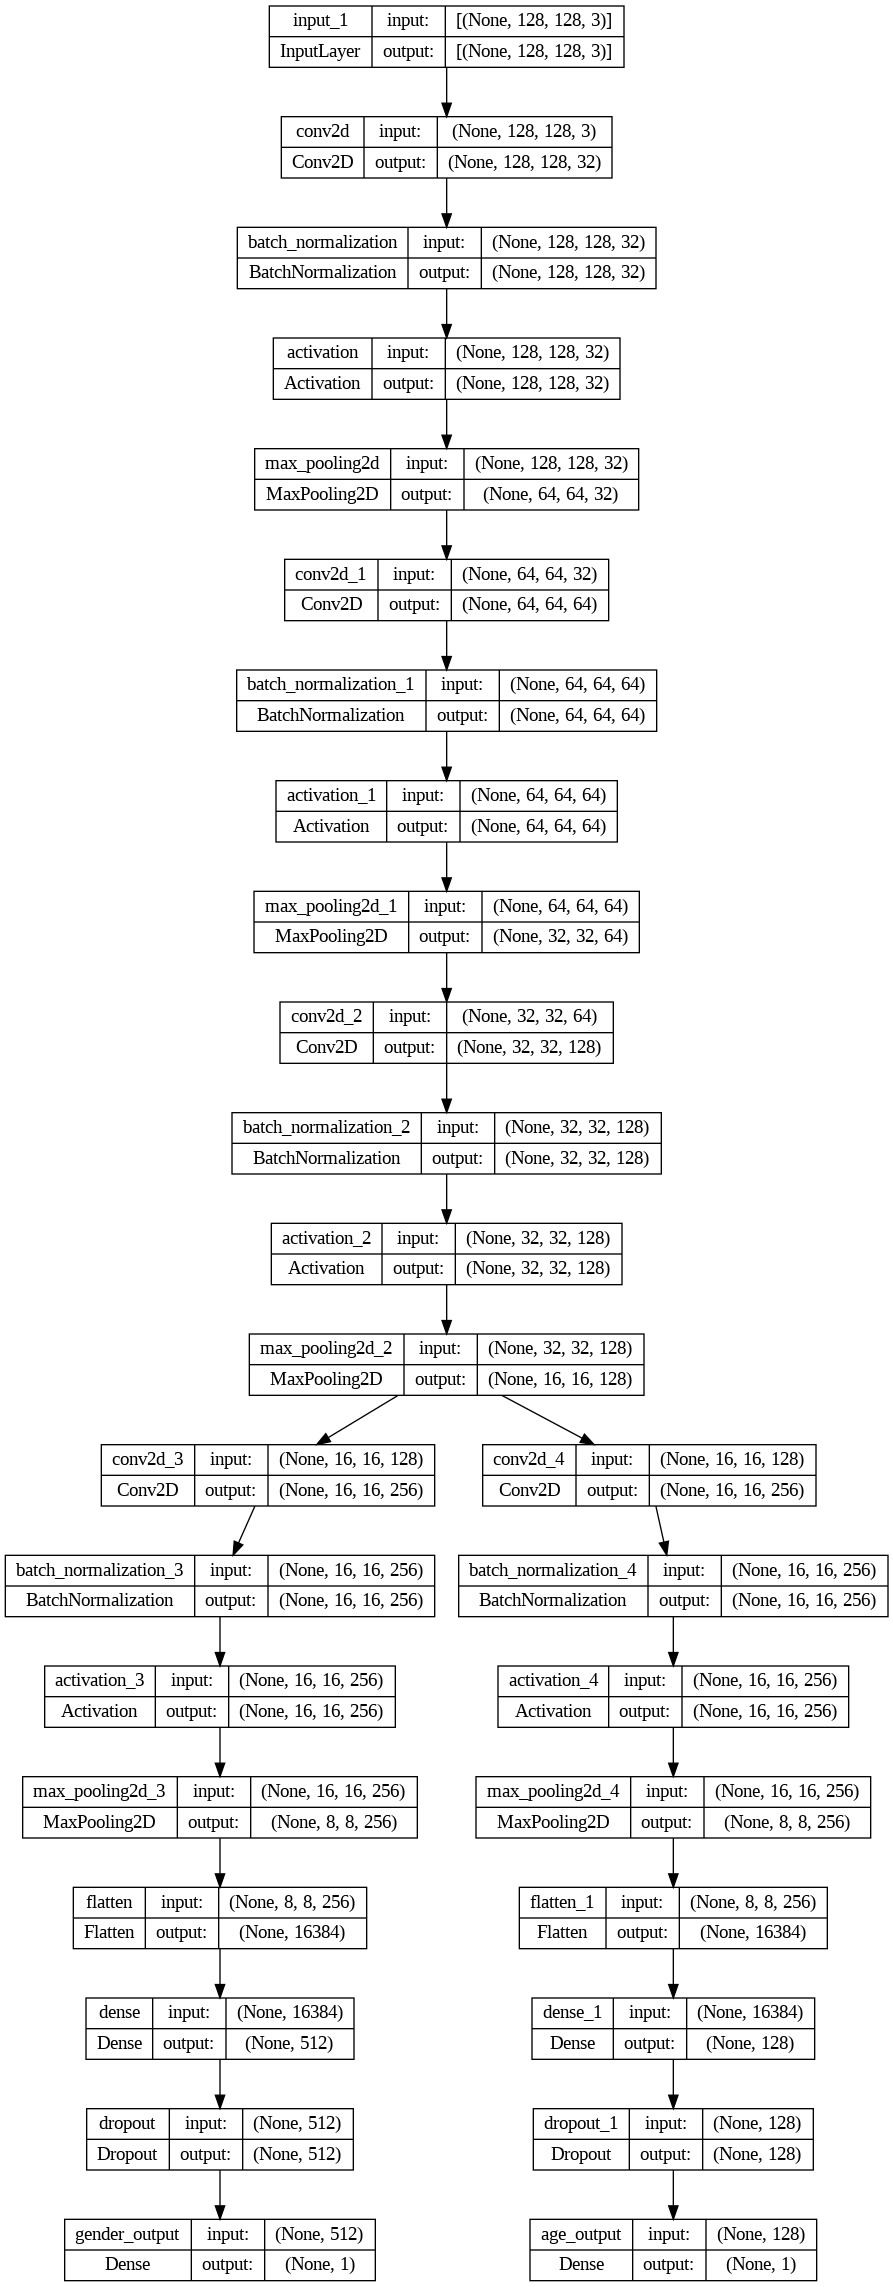

In [ ]:
inputs = Input(shape=(128, 128, 3))

x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

#Split into gender and age

gender_branch = Conv2D(256, kernel_size=(3, 3), padding='same')(x)
gender_branch = BatchNormalization()(gender_branch)
gender_branch = Activation('relu')(gender_branch)
gender_branch = MaxPooling2D(pool_size=(2, 2))(gender_branch)
gender_branch = Flatten()(gender_branch)
gender_branch = Dense(512, activation='relu')(gender_branch)
gender_branch = Dropout(0.5)(gender_branch)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

age_branch = Conv2D(256, kernel_size=(3, 3), padding='same')(x)
age_branch = BatchNormalization()(age_branch)
age_branch = Activation('relu')(age_branch)
age_branch = MaxPooling2D(pool_size=(2, 2))(age_branch)
age_branch = Flatten()(age_branch)
age_branch = Dense(128, activation='relu')(age_branch)
age_branch = Dropout(0.3)(age_branch)
age_output = Dense(1, activation='relu', name='age_output')(age_branch)

modelA = Model(inputs=inputs, outputs=[gender_output, age_output])
modelA.summary()
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by

`modelA = load_model(model_folder+"age_gender_A.h5")`.


In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

modelA.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mae'
    }
)

In [ ]:
callback = LearningRateScheduler(scheduler)

es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

historyA = modelA.fit(
    train_generator,
    epochs=150,
    validation_data=val_generator,
    callbacks=[es_callback,callback]
)


Epoch 1/150
250/250 [==============================] - 135s 489ms/step - loss: 386.0761 - gender_output_loss: 1.4119 - age_output_loss: 384.6645 - gender_output_accuracy: 0.6131 - age_output_mae: 15.0037 - val_loss: 462.4079 - val_gender_output_loss: 0.6569 - val_age_output_loss: 461.7510 - val_gender_output_accuracy: 0.6110 - val_age_output_mae: 18.2333 - lr: 0.0010
Epoch 2/150
250/250 [==============================] - 35s 142ms/step - loss: 305.6219 - gender_output_loss: 0.6091 - age_output_loss: 305.0128 - gender_output_accuracy: 0.6660 - age_output_mae: 13.2983 - val_loss: 214.4577 - val_gender_output_loss: 0.5668 - val_age_output_loss: 213.8909 - val_gender_output_accuracy: 0.6980 - val_age_output_mae: 10.8717 - lr: 0.0010
Epoch 3/150
250/250 [==============================] - 32s 129ms/step - loss: 269.9406 - gender_output_loss: 0.5805 - age_output_loss: 269.3602 - gender_output_accuracy: 0.6845 - age_output_mae: 12.5646 - val_loss: 238.7657 - val_gender_output_loss: 0.5346 - va

In [ ]:
model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
if not os.path.exists(model_folder):
    os.makedirs(model_folder, exist_ok=True)

modelA.save(model_folder + "/age_gender_A.h5")

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


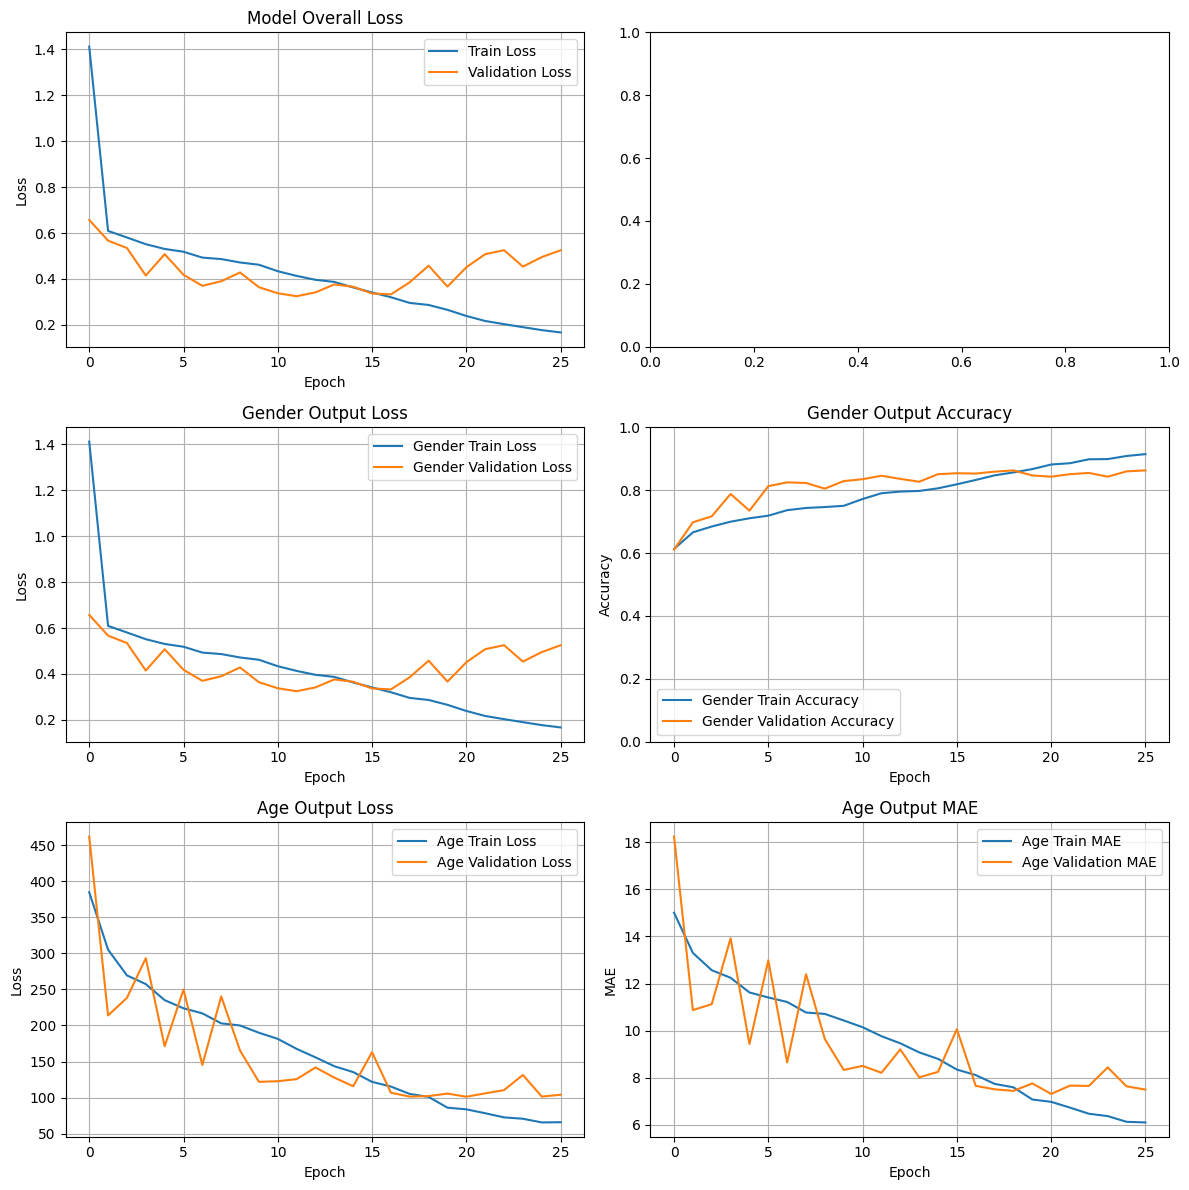

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].plot(historyA.history['gender_output_loss'], label='Train Loss')
axs[0, 0].plot(historyA.history['val_gender_output_loss'], label='Validation Loss')
axs[0, 0].set_title('Model Overall Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[1, 0].plot(historyA.history['gender_output_loss'], label='Gender Train Loss')
axs[1, 0].plot(historyA.history['val_gender_output_loss'], label='Gender Validation Loss')
axs[1, 0].set_title('Gender Output Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(historyA.history['gender_output_accuracy'], label='Gender Train Accuracy')
axs[1, 1].plot(historyA.history['val_gender_output_accuracy'], label='Gender Validation Accuracy')
axs[1, 1].set_title('Gender Output Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_ylim([0, 1])

axs[2, 0].plot(historyA.history['age_output_loss'], label='Age Train Loss')
axs[2, 0].plot(historyA.history['val_age_output_loss'], label='Age Validation Loss')
axs[2, 0].set_title('Age Output Loss')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].legend()
axs[2, 0].grid(True)

axs[2, 1].plot(historyA.history['age_output_mae'], label='Age Train MAE')
axs[2, 1].plot(historyA.history['val_age_output_mae'], label='Age Validation MAE')
axs[2, 1].set_title('Age Output MAE')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('MAE')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()

## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                           

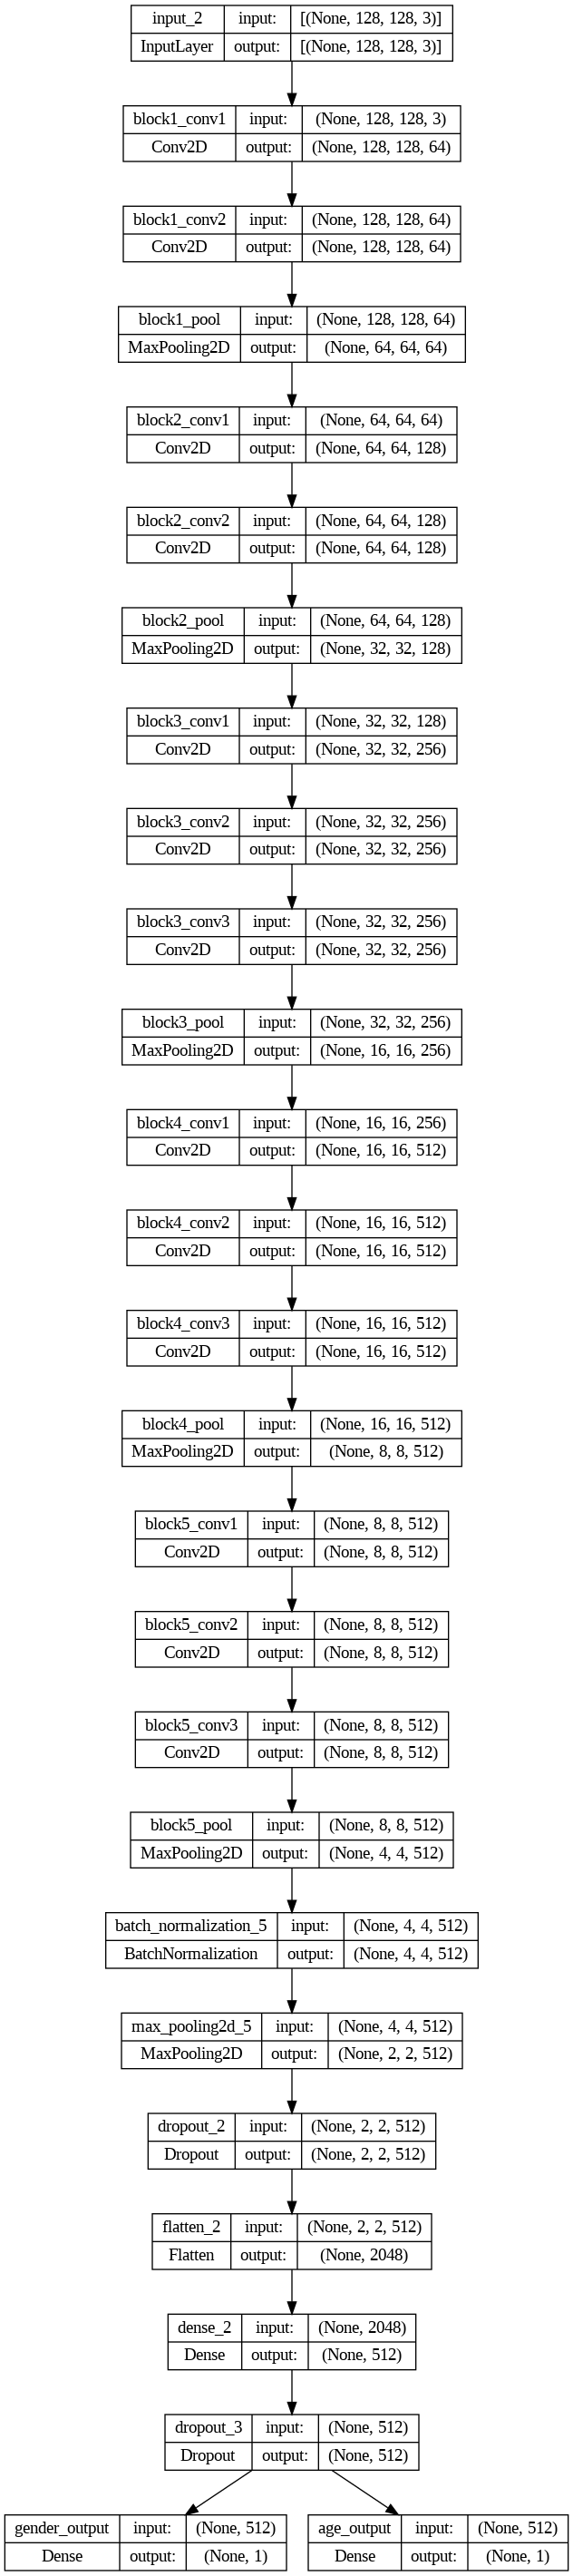

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
age_output = Dense(1, activation='relu', name='age_output')(x)

modelB = Model(inputs=base_model.input, outputs=[gender_output, age_output])

modelB.summary()

plot_model(modelB,show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.h5` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

modelB.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mae'
    }
)

In [ ]:
callback = LearningRateScheduler(scheduler)

es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

historyB = modelB.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[es_callback,callback]
)

Epoch 1/50
250/250 [==============================] - 41s 138ms/step - loss: 285.8044 - gender_output_loss: 1.1370 - age_output_loss: 284.6674 - gender_output_accuracy: 0.5721 - age_output_mae: 12.9566 - val_loss: 279.8764 - val_gender_output_loss: 0.6210 - val_age_output_loss: 279.2554 - val_gender_output_accuracy: 0.6320 - val_age_output_mae: 12.7557 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - 32s 128ms/step - loss: 229.9690 - gender_output_loss: 0.7491 - age_output_loss: 229.2198 - gender_output_accuracy: 0.6286 - age_output_mae: 11.5878 - val_loss: 164.4018 - val_gender_output_loss: 0.5442 - val_age_output_loss: 163.8575 - val_gender_output_accuracy: 0.7370 - val_age_output_mae: 9.5008 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - 32s 130ms/step - loss: 217.3364 - gender_output_loss: 0.6671 - age_output_loss: 216.6693 - gender_output_accuracy: 0.6438 - age_output_mae: 11.2830 - val_loss: 166.4467 - val_gender_output_loss: 0.5597 - val_age

In [ ]:
model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
modelB.save(model_folder + "/age_gender_B.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

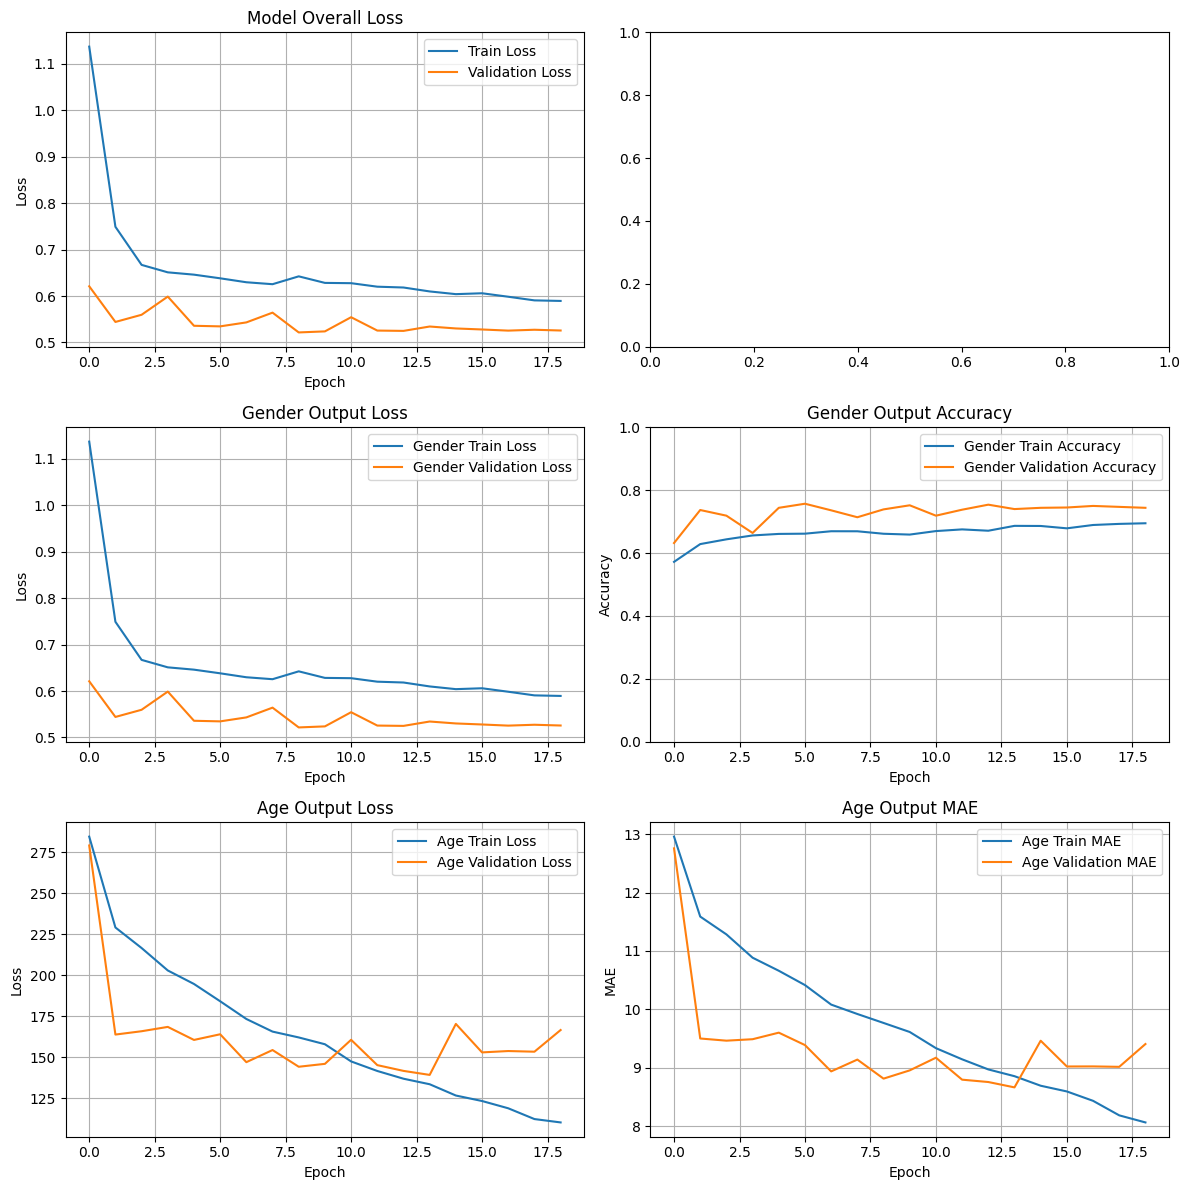

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].plot(historyB.history['gender_output_loss'], label='Train Loss')
axs[0, 0].plot(historyB.history['val_gender_output_loss'], label='Validation Loss')
axs[0, 0].set_title('Model Overall Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[1, 0].plot(historyB.history['gender_output_loss'], label='Gender Train Loss')
axs[1, 0].plot(historyB.history['val_gender_output_loss'], label='Gender Validation Loss')
axs[1, 0].set_title('Gender Output Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(historyB.history['gender_output_accuracy'], label='Gender Train Accuracy')
axs[1, 1].plot(historyB.history['val_gender_output_accuracy'], label='Gender Validation Accuracy')
axs[1, 1].set_title('Gender Output Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_ylim([0, 1])

axs[2, 0].plot(historyB.history['age_output_loss'], label='Age Train Loss')
axs[2, 0].plot(historyB.history['val_age_output_loss'], label='Age Validation Loss')
axs[2, 0].set_title('Age Output Loss')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].legend()
axs[2, 0].grid(True)

axs[2, 1].plot(historyB.history['age_output_mae'], label='Age Train MAE')
axs[2, 1].plot(historyB.history['val_age_output_mae'], label='Age Validation MAE')
axs[2, 1].set_title('Age Output MAE')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('MAE')
axs[2, 1].legend()
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#